# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from typing import Union
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
sns.set()

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Młody\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
DATA_PATH = "./mental-health.csv"
BATCH_SIZE = 32
EPOCHS = 100
EMBEDDING_DIMENSIONS = 200
ENGLISH_STOPWORDS = set(stopwords.words("english"))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Functions

In [5]:
def load_data(path: str):
    dataset = pd.read_csv(path)
    descriptions = dataset["text"]
    symptoms = dataset["label"]
    return descriptions, symptoms

In [6]:
def delete_stopwords_from_doc(doc: str):
    doc = word_tokenize(doc)
    doc = [word.lower() for word in doc if word.lower() not in ENGLISH_STOPWORDS and word.isalpha()]
    return doc

In [7]:
def get_vocab_and_vocab_size(docs: pd.Series):
    all_words = []
    for doc in docs:
        all_words.extend(doc)
    vocab = set(all_words)
    return vocab, len(vocab)

In [8]:
def convert_sentence_to_vector(doc: Union[pd.Series, list[str]], word2index):
    vector = [word2index[word] for word in doc]
    return vector

In [9]:
def convert_sentence_to_tensor(doc: Union[pd.Series, list[str]]):
    return torch.as_tensor(doc)

In [10]:
def get_longest_sentence(doc_table: pd.Series) -> int:
    doc_list = doc_table.tolist()
    longest_sentence = float("-inf")

    for s in doc_list:
        sentence_len = len(s)
        if sentence_len > longest_sentence:
            longest_sentence = sentence_len
    
    return longest_sentence

In [11]:
def add_padding(doc, longest_sentence: int):
    doc_len = len(doc)
    if doc_len < longest_sentence:
        padding = longest_sentence - doc_len
        doc += [0] * padding
    return doc

# Data exploration

In [12]:
X, y = load_data(DATA_PATH)

In [13]:
len(X), len(y)

(20364, 20364)

In [14]:
unique_labels = y.unique()

In [15]:
depression_symptom_num = len(y[y == "depression"])
suicide_symptom_num = len(y[y == "SuicideWatch"])
depression_symptom_num, suicide_symptom_num

(10371, 9993)

Text(0.5, 0, 'No. of occurences in dataset')

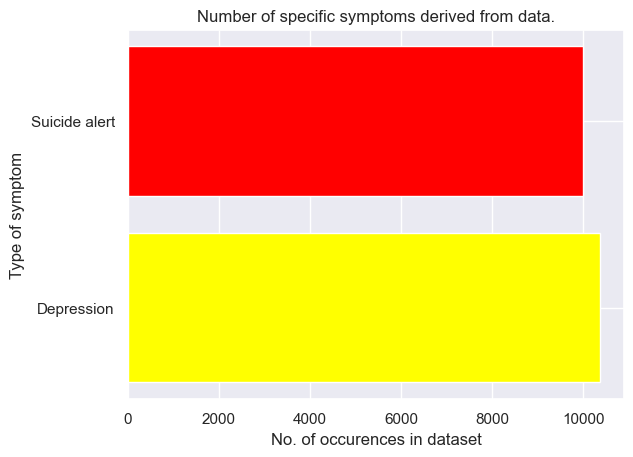

In [16]:
labels = ["Depression", "Suicide alert"]
values = [depression_symptom_num, suicide_symptom_num]

fig, ax = plt.subplots()

ax.set_title("Number of specific symptoms derived from data.")
ax.barh(labels, values, color=["yellow", "red"])
plt.ylabel("Type of symptom")
plt.xlabel("No. of occurences in dataset")

# Data preparation

In [17]:
encoder = LabelEncoder()
encoder.fit(unique_labels)
encoder.classes_,

(array(['SuicideWatch', 'depression'], dtype=object),)

In [18]:
X = X.apply(delete_stopwords_from_doc)

In [19]:
vocab, vocab_size = get_vocab_and_vocab_size(X)

In [20]:
vocab_size

33634

In [21]:
word2index = {word: index for index, word in enumerate(vocab)}

In [22]:
longest_sentence = get_longest_sentence(X)

In [23]:
for i in range(len(X)):
    X.loc[i] = convert_sentence_to_vector(X.loc[i], word2index)
    X.loc[i] = add_padding(X.loc[i], longest_sentence)
    X.loc[i] = convert_sentence_to_tensor(X.loc[i])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

# Building dataloaders

In [26]:
class Loader(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X.to_list()
        self.y = y

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        return self.X[index], self.y[index]

In [27]:
train_loader = Loader(X_train, y_train)
test_loader = Loader(X_test, y_test)

In [28]:
train_iterator = DataLoader(train_loader, batch_size=BATCH_SIZE, shuffle=False)
test_iterator = DataLoader(test_loader, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
x, y = next(iter(train_iterator))

# Building model

In [35]:
class Detector(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        
        self.model = nn.Sequential(
            nn.EmbeddingBag(vocab_size, EMBEDDING_DIMENSIONS, sparse=False),
            nn.Linear(EMBEDDING_DIMENSIONS, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

In [36]:
model = Detector(vocab_size)
model.to(DEVICE)

Detector(
  (model): Sequential(
    (0): EmbeddingBag(33634, 200, mode='mean')
    (1): Linear(in_features=200, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=64, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [39]:
model_optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(model_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [44]:
training_losses = []
learning_rates = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    model.train()
    
    for input, labels in tqdm(train_iterator):
        labels = labels.unsqueeze(1).to(torch.double).to(DEVICE)
        model_optimizer.zero_grad()
        outputs = model(input.to(DEVICE))
        print(outputs, labels)
        break
        loss = criterion(outputs, labels.to(torch.double))
        loss.backward()
        
        training_losses.append(loss.item())
        learning_rates.append(model_optimizer.param_groups[0]['lr'])
        

        model_optimizer.step()
    break
    clear_output(wait=True)
    plt.plot(training_losses)
    plt.plot(learning_rates)
    plt.show()
    scheduler.step(loss.item())
    print(f'Epoch [{epoch+1}/{epoch}], {loss.item()}')

Epoch 0


  0%|          | 0/478 [00:00<?, ?it/s]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]], device='cuda:0', dtype=torch.float64)


In [34]:
test_losses = []
model.eval()

with torch.no_grad():
    for input, labels in tqdm(test_iterator):
        labels = labels.unsqueeze(1).to(torch.double).to(DEVICE)
        outputs = model(input.to(DEVICE))
        loss = criterion(outputs, labels.to(torch.double))
        test_losses.append(loss.item())

# Compute average test loss
avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {avg_test_loss}')

  7%|▋         | 11/160 [00:00<00:01, 106.80it/s]

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]], device='cuda:0', dtype=torch.float64) tensor([[2.7326e-16],
        [2.6510e-16],
        [4.9613e-16],
        [3.0346e-16],
        [8.6645e-16],
        [2.9566e-16],
        [2.7692e-16],
        [2.0266e-16],
        [2.5967e-16],
        [7.4905e-16],
        [2.4394e-16],
        [3.0015e-16],
        [5.3176e-16],
        [5.9859e-16],
        [3.1940e-15],
        [1.2754e-15],
        [3.1189e-16],
        [2.2819e-16],
        [6.3802e-16],
        [2.9779e-16],
        [4.2473e-16],
        [2.0272e-16],
        [4.5773e-15],
       

 21%|██▏       | 34/160 [00:00<00:01, 109.63it/s]

tensor([[3.4896e-16],
        [3.7315e-16],
        [8.3643e-16],
        [4.7187e-16],
        [2.2234e-16],
        [2.1242e-16],
        [2.3033e-16],
        [5.8532e-16],
        [2.6761e-16],
        [1.4580e-14],
        [1.7930e-16],
        [7.5011e-16],
        [3.1786e-16],
        [2.0399e-16],
        [5.9886e-16],
        [1.3145e-15],
        [3.5055e-16],
        [1.0399e-15],
        [1.8235e-16],
        [2.1495e-16],
        [2.8574e-15],
        [2.1370e-16],
        [3.2236e-16],
        [2.1717e-16],
        [1.8301e-16],
        [7.9223e-16],
        [3.4478e-16],
        [4.7454e-16],
        [1.9824e-15],
        [2.4937e-16],
        [5.0330e-16],
        [2.0338e-16]], device='cuda:0')
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]

 42%|████▏     | 67/160 [00:00<00:00, 108.66it/s]

tensor([[3.6648e-16],
        [9.2150e-16],
        [2.7089e-16],
        [1.3863e-14],
        [3.6028e-16],
        [1.7841e-15],
        [6.9295e-16],
        [3.9632e-16],
        [2.7794e-16],
        [9.7328e-16],
        [5.5128e-16],
        [2.8945e-16],
        [2.8785e-16],
        [2.1858e-16],
        [4.9563e-16],
        [1.8970e-16],
        [9.4383e-15],
        [3.0099e-16],
        [4.3040e-16],
        [2.3199e-16],
        [4.1207e-16],
        [1.4738e-13],
        [2.5959e-16],
        [7.5183e-16],
        [5.2474e-16],
        [5.5513e-16],
        [7.4299e-16],
        [2.3594e-16],
        [5.1934e-16],
        [2.1330e-16],
        [2.3267e-16],
        [2.6032e-15]], device='cuda:0')
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]

 49%|████▉     | 79/160 [00:00<00:00, 109.15it/s]

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', dtype=torch.float64) tensor([[3.2553e-16],
        [1.9002e-16],
        [1.6011e-15],
        [2.1260e-16],
        [2.1579e-16],
        [4.2996e-16],
        [2.7350e-16],
        [1.9834e-16],
        [5.9373e-16],
        [5.8572e-16],
        [5.4557e-16],
        [4.6285e-16],
        [3.3418e-16],
        [3.7298e-16],
        [3.0802e-16],
        [3.0170e-16],
        [2.9814e-16],
        [2.7505e-16],
        [5.5696e-16],
        [3.9846e-16],
        [3.7237e-16],
        [5.2861e-16],
        [3.1063e-16],
       

 63%|██████▎   | 101/160 [00:00<00:00, 103.87it/s]

tensor([[2.1476e-16],
        [3.7104e-16],
        [1.9965e-16],
        [6.3686e-15],
        [3.3391e-16],
        [1.8538e-15],
        [1.3486e-15],
        [4.4596e-16],
        [1.4706e-15],
        [2.6953e-16],
        [2.3159e-16],
        [2.7998e-16],
        [1.1852e-15],
        [4.7557e-16],
        [1.9230e-16],
        [2.2638e-16],
        [2.6165e-15],
        [2.8616e-16],
        [1.0025e-15],
        [2.3275e-16],
        [2.8117e-16],
        [2.2634e-16],
        [1.8725e-16],
        [2.1007e-16],
        [2.6197e-16],
        [4.4400e-16],
        [2.2335e-16],
        [3.5080e-16],
        [7.3906e-16],
        [1.9304e-16],
        [1.8373e-16],
        [1.7823e-16]], device='cuda:0')
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]

 77%|███████▋  | 123/160 [00:01<00:00, 104.90it/s]

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0', dtype=torch.float64) tensor([[1.9358e-16],
        [6.0440e-16],
        [2.1010e-16],
        [2.3115e-16],
        [2.0755e-16],
        [2.1419e-16],
        [7.2693e-16],
        [4.8646e-16],
        [7.2059e-16],
        [8.2705e-16],
        [6.6166e-16],
        [3.6878e-16],
        [3.4842e-16],
        [1.0391e-15],
        [2.0275e-16],
        [3.3010e-16],
        [2.5458e-16],
        [2.7068e-16],
        [3.8318e-16],
        [8.7317e-16],
        [5.6793e-16],
        [2.5854e-16],
        [2.1452e-16],
       

 92%|█████████▏| 147/160 [00:01<00:00, 108.44it/s]

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', dtype=torch.float64) tensor([[1.8431e-16],
        [1.3958e-13],
        [6.1360e-16],
        [3.0109e-16],
        [1.1130e-15],
        [3.9745e-15],
        [2.1734e-16],
        [2.8573e-16],
        [2.0022e-16],
        [8.3521e-15],
        [3.0804e-16],
        [2.7098e-16],
        [2.0555e-16],
        [2.2066e-16],
        [1.8747e-16],
        [3.7723e-16],
        [4.3376e-16],
        [2.2833e-16],
        [3.5684e-16],
        [1.9863e-16],
        [3.4699e-16],
        [3.5133e-16],
        [3.7520e-16],
       

100%|██████████| 160/160 [00:01<00:00, 108.11it/s]

tensor([[2.2841e-16],
        [3.0737e-16],
        [2.2418e-16],
        [1.8229e-16],
        [2.2029e-16],
        [2.2128e-16],
        [1.9169e-16],
        [2.2888e-16],
        [2.1330e-16],
        [3.1364e-16],
        [2.2673e-15],
        [2.9995e-16],
        [2.3792e-16],
        [1.4794e-15],
        [2.9675e-16],
        [2.0501e-16],
        [3.3814e-16],
        [3.9742e-16],
        [3.4533e-16],
        [5.9665e-16],
        [2.1620e-16],
        [7.1450e-16],
        [1.1266e-15],
        [8.6449e-16],
        [2.1280e-16],
        [4.1524e-16],
        [2.4068e-16],
        [3.1492e-16],
        [1.9380e-16],
        [3.7975e-16],
        [2.7061e-16],
        [2.4730e-16]], device='cuda:0')
tensor([[1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]